# Packages and Functions

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import dirichlet
from scipy.special import logsumexp, gammaln, digamma, polygamma
from datetime import datetime
import pickle
from sklearn.preprocessing import MultiLabelBinarizer

In [5]:
def logdotexp(A, B):
    max_A = np.max(A)
    max_B = np.max(B)
    C = np.dot(np.exp(A - max_A), np.exp(B - max_B))
    np.log(C, out=C)
    C += max_A + max_B
    return C

#Data Processing and Saving


Drop duplicates

Add movie code to each line and saving as numpy format

Date of rating kept as string to reduce file size

Combined all datasets into one

Sort based on user then date and save dataset as single npy file

In [ ]:
path = '/content/drive/MyDrive/PhD/Modules/IS6101 Topics in Machine Learning and Optimization/HMM for CF/Data and Parameters/'
file = 'combined_data_4.txt' # change filename to partial dataset to process

In [ ]:
# load dataset as dataframe

df = pd.read_csv(path + file, sep=',', header=None, names=['user', 'rating', 'date'])
print(df.shape)
df.drop_duplicates(inplace=True) # remove duplicate entries which are numerous
df.reset_index(drop=True, inplace=True) 
print(df.shape)
print(df.loc[:5])

(26851926, 3)
(12700401, 3)
      user  rating        date
0   13368:     NaN         NaN
1  2385003     4.0  2004-07-08
2   659432     3.0  2005-03-16
3   751812     2.0  2002-12-16
4  2625420     2.0  2004-05-25
5  1650301     1.0  2005-08-30


In [ ]:
# create numpy array of starting indices for each movie id

df_movies = df[df['rating'].isna()]
df_movies = df_movies['user']
df_movies = df_movies.rename('movie_id')
df_movies = df_movies.map(lambda x: x.rstrip(':'))
np_movies = np.stack([df_movies.index.to_numpy(), df_movies.to_numpy()], axis=-1)
np_movies[:,1] = np_movies[:,1].astype(int)
print(np_movies[:5])

[[0 13368]
 [528 13369]
 [679 13370]
 [3395 13371]
 [3508 13372]]


In [ ]:
# add column to df to include movie id with dataframes

# df['movie_id'] = None
# for i in range(np_movies.shape[0] - 1):
#     # df.iloc[np_movies[i, 0]+1: np_movies[i+1, 0]]['movie_id'] = np_movies[i, 1]
#     df.loc[(np_movies[i,0]+1):(np_movies[i+1,0]-1), 'movie_id'] = np_movies[i, 1] 
# df.loc[(np_movies[-1,0]+1):, 'movie_id'] = np_movies[-1, 1]
# df = df.dropna()

In [ ]:
# add column to df to include movie id with numpy arrays

df.insert(1, 'movie_id', None)
np_ratings = df.to_numpy()

# loop to insert movie_ids until the penultimate movie id
for i in range(np_movies.shape[0] - 1):
    np_ratings[(np_movies[i,0]+1):(np_movies[i+1,0]), 1] = np_movies[i, 1]

# insert the last movie id
np_ratings[(np_movies[-1,0]+1):, 1] = np_movies[-1, 1]

# delete rows that are movie id rows
np_ratings = np.delete(np_ratings, np_movies[:,0].astype(int), axis=0)

# set user id, movie id and rating to integers
np_ratings[:, :-1] = np_ratings[:, :-1].astype(int)

# print first 5 samples
print(np_ratings[:5])

[[2385003 13368 4 '2004-07-08']
 [659432 13368 3 '2005-03-16']
 [751812 13368 2 '2002-12-16']
 [2625420 13368 2 '2004-05-25']
 [1650301 13368 1 '2005-08-30']]


In [ ]:
np.save(path + 'combined_data_4', np_ratings)

In [ ]:
# combine 4 datasets into 1 dataset

dataset = np.load(path + 'combined_data_1.npy', allow_pickle=True)
for i in range(2, 5):
    sub_dataset = np.load(path+'combined_data_' + str(i) + '.npy', allow_pickle=True)
    dataset = np.concatenate([dataset, sub_dataset], axis=0)
print(dataset[:5])
print(dataset.shape)

[[1488844 1 3 '2005-09-06']
 [822109 1 5 '2005-05-13']
 [885013 1 4 '2005-10-19']
 [30878 1 4 '2005-12-26']
 [823519 1 3 '2004-05-03']]
(48842648, 4)


In [ ]:
# sort dataset according to date then user

dataset = dataset[np.lexsort((dataset[:,0], dataset[:,-1]))]

In [ ]:
np.save(path + 'netflix_combined_data', dataset)

# Trimming Data Based on Minimum Number of Ratings Threshold


In [ ]:
# load the full dataset

path = '/content/drive/MyDrive/PhD/Modules/IS6101 Topics in Machine Learning and Optimization/HMM for CF/Data and Parameters'
dataset = np.load(path + 'netflix_combined_data.npy', allow_pickle=True)
# dataset[:,-1] = dataset[:,-1].astype(np.datetime64)
print(dataset[:5])
print(dataset.shape)
np.max(dataset[:,1])   # number of movie titles

[[510180 1367 5 '1999-11-11']
 [510180 2866 3 '1999-11-11']
 [510180 3730 4 '1999-11-11']
 [510180 3870 2 '1999-11-11']
 [510180 5571 4 '1999-11-11']]
(48842648, 4)


17770

In [ ]:
# check number of unique users

unique_users, user_counts = np.unique(dataset[:,0], return_counts=True)
print(unique_users) # user_ids
print(user_counts) # number of records for user_id
print(len(unique_users)) # number of records for user_id

[6 7 8 ... 2649421 2649426 2649429]
[261 179  15 ...  12 246 166]
480189


In [ ]:
# filter users with > n number of ratings made

n = 1000
print(np.sum(user_counts > n))
selected_users = unique_users[user_counts > n]
selected_users[:5]

874


array([5980, 6629, 8200, 8660, 10268], dtype=object)

In [ ]:
# partially process a fixed number of users to add into filtered dataset (>n ratings) 
# as process takes too long to complete in one run

# dataset_threshold = np.load(path + 'netflix_400_threshold.npy', allow_pickle=True)  # load previously filtered dataset (>n ratings)

num_users = 874
dataset_threshold = np.empty((0,4)) # run if no existing filtered dataset exists
for user in selected_users[:num_users]:
    dataset_threshold = np.concatenate((dataset_threshold, dataset[dataset[:,0] == user]))  # add records of new selected user to filtered dataset

selected_users = selected_users[num_users:]  # save selected users that are not processed yet

In [ ]:
np.save(path + 'netflix_1000_threshold', dataset_threshold)
np.save(path + 'selected_users_1000', selected_users)

# Load Filtered Data

In [ ]:
# retrieve netflix data for users with > n ratings

path = '/content/drive/MyDrive/PhD/Modules/IS6101 Topics in Machine Learning and Optimization/HMM for CF/Data and Parameters/'
dataset_threshold = np.load(path + 'netflix_1000_threshold.npy', allow_pickle=True)
dataset_threshold[:,-1] = dataset_threshold[:,-1].astype(np.datetime64)
dataset_threshold = dataset_threshold[np.lexsort((dataset_threshold[:,-1], dataset_threshold[:,0]))] # sort by user then date

In [ ]:
N = np.max(dataset_threshold[:,1])   # number of movie titles
N

17770

In [ ]:
unique_users, user_counts = np.unique(dataset_threshold[:,0], return_counts=True)
U = len(unique_users) # total number of users in the dataset
U

874

In [ ]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

start_date = np.min(dataset_threshold[:,3])
end_date = np.max(dataset_threshold[:,3])

T = diff_month(end_date, start_date) + 1 # total number of months in the dataset 
T

73

# Process Filtered Data (Non-Sparse Tensors)

In [ ]:
U = 100 # number of desired users in the dataset to be constructed

users_ds = np.empty((U,T,N), dtype=int)
user_count = 0
for user in unique_users[:U]: # process one user at a time
    dataset_single = dataset_threshold[dataset_threshold[:,0] == user]
    dataset_labels = [] 
    for t in range(T): # create label vector for each time period for this user
        dataset_labels.append([row[1] for row in dataset_single if diff_month(row[-1], start_date) == t])
    dataset_labels = np.array(dataset_labels, dtype=object) 
    mlb = MultiLabelBinarizer(range(1,N+1), sparse_output=False)
    users_ds[user_count] = mlb.fit_transform(dataset_labels) # convert label vectors to one hot vectors
    user_count += 1
np.shape(users_ds)

(100, 73, 17770)

In [ ]:
users_Nt = np.sum(users_ds, axis=-1) # number of movies rated by user in each time period
T = np.shape(users_ds)[1] # final length of time period after trimming
users_Nt.shape 

(100, 73)

In [ ]:
Nt_sum = users_Nt.sum(axis=0)
Nt_sum

array([   0,  137,  159,  321,  131,  114,  216,  277,  203,  171,  242,
        187,  445,  356,  430,  485,  264,  379,  416,  561,  555,  457,
        522,  656,  844, 1228,  955, 1082, 1514, 1460, 1638, 2005, 2297,
       2378, 2433, 2227, 2059, 1840, 1497, 1955, 1907, 2099, 2278, 2359,
       3158, 2818, 3021, 2382, 2538, 2770, 2824, 3272, 3358, 3524, 3401,
       3326, 3528, 3419, 3026, 3104, 3312, 2865, 2440, 2523, 2655, 2538,
       2639, 2342, 2555, 2244, 2372, 1764, 1251])

In [ ]:
# trim dataset until first time period with at least one user rating available

for t in range(T):
    if users_Nt[:,0].sum() == 0:
        users_ds = users_ds[:,1:,:]
        users_Nt = users_Nt[:,1:]
    else:
        break

T = np.shape(users_ds)[1] # final length of time period after trimming
np.shape(users_ds)

(100, 72, 17770)

# Process Filtered Data (List of Sparse Matrices)

In [ ]:
U = 100 # number of desired users in the dataset to be constructed

users_ds = []
for user in unique_users[:U]: # process one user at a time
    dataset_single = dataset_threshold[dataset_threshold[:,0] == user]
    dataset_labels = [] 
    for t in range(T): # create label vector for each time period for this user
        dataset_labels.append([row[1] for row in dataset_single if diff_month(row[-1], start_date) == t])
    dataset_labels = np.array(dataset_labels, dtype=object) 
    mlb = MultiLabelBinarizer(range(1,N+1), sparse_output=True)
    users_ds.append(mlb.fit_transform(dataset_labels)) # convert label vectors to sparse one hot vectors

len(users_ds), users_ds[0].shape

(100, (73, 17770))

In [ ]:
# calculate number of movies rated by user in each time period

users_Nt = []
for i in range(len(users_ds)):
    user_sum = users_ds[i].sum(axis=-1)
    user_sum = np.array([row[0,0] for row in user_sum]) # for some reason, flatten/squeeze doesn't work
    users_Nt.append(user_sum)
    
len(users_Nt), users_Nt[0].shape

(100, (73,))

In [ ]:
# remove any initial periods with no ratings from any user

for t in range(T):
    Nt_sum = np.array([user[t] for user in users_Nt]).sum() # total number of user ratings in period t
    if Nt_sum == 0:
        users_ds = [user[1:,:] for user in users_ds]
        users_Nt = [user[1:] for user in users_Nt]
    else:
        break

users_ds[0]
T = np.shape(users_ds[0])[0] # final length of time period
T

72

In [ ]:
# find total number of ratings across all time periods and users for each movie

movie_sum = np.array([user.sum(axis=0) for user in users_ds]).sum(axis=0)
movie_sum = movie_sum.flatten()
movie_sum.shape

(17770,)

In [ ]:
# remove movies with zero views across all time periods and users

index = movie_sum > 0 # boolean index to keep only movies with at least 1 ratings across users and time periods
users_ds = [user[:,index] for user in users_ds]
shape = users_ds[0].shape
test_user_ds_shape = [user.shape == shape for user in users_ds] # boolean vector to check if all shapes are the same
shape, len(users_ds), np.sum(test_user_ds_shape) # all single user datasets have same #items if sum = U

((73, 17606), 874, 874)

# Save List of Sparse Matrices

In [ ]:
path = '/content/drive/MyDrive/PhD/Modules/IS6101 Topics in Machine Learning and Optimization/HMM for CF/Data and Parameters/'
pickle.dump(users_ds, open(path + 'users_ds.pkl','wb'))

# Load List of Sparse Matrices

In [6]:
path = '/content/drive/MyDrive/PhD/Modules/IS6101 Topics in Machine Learning and Optimization/HMM for CF/Data and Parameters/'
users_ds = pickle.load(open(path + 'users_ds.pkl','rb'))

In [7]:
U = len(users_ds)
T = users_ds[0].shape[0]
N = users_ds[0].shape[1]
U, T, N

(874, 73, 17606)

In [8]:
t_predict = -2
test_ds = [user[t_predict,:] for user in users_ds]
users_ds = [user[47:t_predict,:] for user in users_ds]

In [9]:
len(test_ds), test_ds[0].shape[0], test_ds[0].shape[1]

(874, 1, 17606)

In [10]:
U = len(users_ds)
T = users_ds[0].shape[0]
N = users_ds[0].shape[1]
U, T, N

(874, 24, 17606)

In [11]:
# calculate and store total number of ratings per user in a period

users_Nt = []
for i in range(len(users_ds)):
    user_sum = users_ds[i].sum(axis=-1)
    user_sum = np.array([row[0,0] for row in user_sum]) # for some reason, flatten/squeeze doesn't work
    users_Nt.append(user_sum)
    
len(users_Nt), users_Nt[0].shape

(874, (24,))

#Initialize all distribution parameters

In [12]:
K = 5 # no of latent classes
# N = 500 # use only for simulated data

prior_const = 100 # affects the parameters of the Dirichlet priors
pi_alpha = prior_const/K * np.ones((K)) # alpha hyperparams for pi
A_alpha = prior_const/K * np.ones((K,K)) # alpha hyperparams for A
theta_alpha = prior_const/K * np.ones((K,N)) # alpha hyperparams for theta
a = np.random.uniform(low=2, high=5, size=(K)) # initialise parameter a randomly
p = np.random.uniform(low=0.6, high=0.8, size=(K)) # initialise parameter p which corresponds to standard multinomial set up 
b = p / (1-p) # derive parameter b for the gamma mixture of poisson distribution which = NBD

pi = dirichlet.rvs(alpha=pi_alpha, size=1) # initialise pi randomly
A = np.zeros((K,K)) 
theta = np.zeros((K,N))
for k in range(K):
    A[k,:] = dirichlet.rvs(alpha=A_alpha[k,:], size=1) 
    theta[k,:] = dirichlet.rvs(alpha=theta_alpha[k,:], size=1) 

A = np.log(A)
pi = np.log(pi)
theta = np.log(theta)

# Setup of simulated data (Single user)

In [ ]:
T = 4 # number of periods
N_t = np.random.randint(5,20,size=(T)) # number of articles read in each period generated randomly
dataset = []
for t in range(T):
    dataset.append(np.random.choice(N, size=N_t[t], replace=False)) # generate random dataset of specific articles read based on N_t in each period
dataset = np.array(dataset, dtype=object)
mlb = MultiLabelBinarizer(range(N))
dataset = mlb.fit_transform(dataset) # convert dataset to one-hot encoding

In [ ]:
dataset.shape, N_t.shape

((4, 500), (4,))

# EM Algorithm Debugging (Single user)

In [ ]:
# Calculate log probability of articles as Gamma mixture of Poisson
p_n_ab = gammaln(N_t[..., np.newaxis] + a[np.newaxis, ...]) \
        - gammaln(a)[np.newaxis, ...] - gammaln(N_t+1)[..., np.newaxis] \
        + N_t[..., np.newaxis] * np.log(b)[np.newaxis, ...]  \
        - (N_t[..., np.newaxis] + a[np.newaxis, ...]) * np.log(b+1)[np.newaxis, ...]

# Calculate log probability of articles read using Scipy multinomial module
# p_i_theta2 = np.zeros((T,K))
# for k in range(K):
#     p_i_theta2[:,k] = multinomial.logpmf(dataset, N_t, np.exp(theta[k]))

# Non-vectorized implementation for verification of above
# p_i_theta2 = np.zeros((T,K))
# for t in range(T):
#     for k in range(K):
#         p_i_theta2[t,k] = multinomial.pmf(dataset[t,:], N_t[t], theta[k,:])


# Calculate the log prob of multinomial distribution using gamma functions
# logprob = log(Nut!) - sum(log(x_i!)) + sum(x_i * log(prob_i))
first_part = gammaln(N_t+1)
second_part = gammaln(dataset+1).sum(axis=1)
third_part = np.dot(dataset, theta.T)
p_i_theta = (first_part - second_part)[..., np.newaxis] + third_part

# calculate log prob of joint distribution of N and I
p_i_z = p_n_ab + p_i_theta

# print(np.exp(p_i_z))
# print(p_i_z.shape)
# p_n_ab - p_n_ab2
# p_i_theta - p_i_theta2
# p_n_ab.shape

In [ ]:
# non-vectorised implementation for verification
# alpha2=alpha
# for t in range(1, T):
#     for k in range(K):
#         alpha2[t,k] = logsumexp(alpha2[t-1,:] + A[:,k]) + p_i_z[t,k]
# alpha - alpha2

alpha = np.zeros((T,K))
alpha[0] = p_i_z[0] + pi
for t in range(1, T):
    alpha[t] = logdotexp(alpha[t-1], A) + p_i_z[t]

alpha

array([[ -62.89191399,  -62.86262428,  -63.10646664,  -62.53659379,
         -65.19201529,  -65.41780978,  -59.08542575,  -66.76241496,
         -59.62264015,  -64.97888758,  -59.00594916,  -61.32490607,
         -64.048625  ,  -60.24339669,  -60.24596066,  -60.25170138,
         -62.4335902 ,  -62.07059153,  -61.08142226,  -62.68584123],
       [-106.55295266, -110.08056478, -106.0130473 , -107.59378081,
        -109.3870104 , -107.69368649, -106.73236558, -109.23906565,
        -108.8727425 , -108.00377795, -108.02567142, -108.77874657,
        -107.01866096, -107.499831  , -106.86748119, -107.565894  ,
        -108.85136546, -110.72114482, -106.78745674, -108.31933764],
       [-154.74669154, -152.22781388, -154.76757655, -153.94529636,
        -152.58697403, -153.05329297, -154.64603962, -153.78936045,
        -154.71589641, -152.86153825, -156.48341143, -155.11672896,
        -154.32826441, -154.41369314, -156.50553258, -156.02430446,
        -154.90231286, -153.67602313, -154.612

In [ ]:
# non-vectorised implementation for verification
# beta2 = beta
# for t in range(T-2, -1, -1):
#     for k in range(K):
#         beta[t,k] = logsumexp(A[k,:] + p_i_z[t+1,:] + beta[t+1,:])
# beta - beta2

beta = np.zeros((T,K))
for t in range(T-2, -1, -1):
    beta[t] = logdotexp(A, (p_i_z[t] + beta[t+1]))

beta

array([[-7.12458276, -7.13352365, -7.42679654, -7.13513551, -7.27325712,
        -7.22891185, -7.29660238, -6.98896691, -7.22809555, -7.12490841,
        -7.04319877, -6.69403554, -7.15264027, -6.9562898 , -7.41002057,
        -6.63314833, -7.09742638, -6.95106509, -7.01217977, -7.38555375],
       [ 3.99702203,  4.09950355,  4.19605185,  3.76752414,  3.61687744,
         3.6989732 ,  3.57975353,  3.56834915,  3.6183167 ,  3.57459961,
         4.00434634,  3.90241211,  3.82568715,  3.83873622,  4.04702132,
         3.46523019,  3.9224641 ,  3.66722009,  3.47583219,  4.01685811],
       [ 3.9118583 ,  4.01058455,  3.79417284,  4.20690292,  4.48155823,
         4.2951229 ,  4.43083436,  4.48669264,  4.46142435,  4.40045467,
         3.92180494,  4.09075336,  4.20867859,  4.24353744,  4.09199988,
         4.51599522,  4.2589245 ,  4.39433669,  4.49492062,  4.16108553],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  

In [ ]:
# p_i = logsumexp(alpha[-1])
# p_z_i = alpha + beta - p_i

p_z_i = alpha + beta - logsumexp(alpha + beta, axis=-1)[...,np.newaxis]
print(p_z_i.shape)
np.exp(p_z_i)

(4, 5)


array([[6.79365529e-01, 4.57530069e-03, 2.12605757e-02, 1.75535688e-02,
        2.77245026e-01],
       [9.88655543e-01, 3.61931283e-05, 1.25579410e-04, 1.01357980e-04,
        1.10813268e-02],
       [7.02015328e-01, 3.75132666e-02, 4.04902836e-02, 7.45673013e-02,
        1.45413821e-01],
       [8.31153367e-01, 5.03786685e-03, 5.74071809e-03, 1.90160689e-02,
        1.39051979e-01]])

In [ ]:
test = [1,2,3]
print(np.shape(test))
print(beta[0,:].shape)
np.tile(test, (3,1)).T

(3,)
(5,)


array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])

In [ ]:
import time

print(alpha.shape, beta.shape, A.shape)

# p_zz_i = np.zeros((T-1,K,K))
# for t in range(T-1):
#     for i in range(K):
#         for j in range(K):
#             p_zz_i[t,i,j] = alpha[t,i] + A[i,j] + p_i_z[t+1,j] + beta[t+1,j]
#     p_zz_i[t] -= logsumexp(p_zz_i[t])

p_zz_i = np.zeros((T-1,K,K))
for t in range(T-1):
    p_zz_i[t,:,:] = np.tile(alpha[t,:], (K,1)).T + A + np.tile(p_i_z[t+1,:], (K,1)) + np.tile(beta[t+1,:], (K,1))    
    p_zz_i[t] -= logsumexp(p_zz_i[t])

# p_zz_i2 - p_zz_i
# gamma_i = logsumexp(p_zz_i, axis=-1)

(4, 5) (4, 5) (5, 5)


In [ ]:
# calculate expected log likelihood of data and check that it is increasing at every iteration 
# to check for bugs and for convergence condition

# intial state 
init = np.sum(np.exp(p_z_i[0]) * pi)

# transitional 
trans = np.sum(np.exp(p_zz_i) * A[np.newaxis,...])

# # of items 
nbd = np.sum(np.exp(p_z_i) * p_n_ab)

# specific item 
multi = np.sum(np.exp(p_z_i) * p_i_theta)

new_likelihood = init + trans + nbd + multi

new_likelihood

-251.08022163991518

In [ ]:
print(np.exp(p_z_i[0]))
pi_alpha += np.exp(p_z_i[0])
pi_alpha

[1.74202873e-28 9.99999648e-01 3.51901414e-07]


array([33.33333333, 34.33333298, 33.33333369])

In [ ]:
pi = (pi_alpha - 1) / (np.sum(pi_alpha) - K)
print(pi)
pi = np.log(pi)

[0.32993197 0.34013605 0.32993198]


In [ ]:
print(p_zz_i.shape)
print(np.sum(np.exp(p_zz_i), axis=0))
count_ij = np.sum(np.exp(p_zz_i), axis=0)
A_alpha += count_ij

(3, 3, 3)
[[4.31916755e-56 2.69574564e-28 9.33107802e-34]
 [7.49785665e-28 2.99999446e+00 3.31939613e-06]
 [4.18937141e-34 2.21605473e-06 3.04189115e-12]]


In [ ]:
A = (A_alpha - 1) / (np.sum(A_alpha, axis=-1) - K)[...,np.newaxis] # to align the division
print(A)
A = np.log(A)

[[0.33333333 0.33333333 0.33333333]
 [0.32333334 0.35333329 0.32333337]
 [0.33333333 0.33333335 0.33333333]]


In [ ]:
print(theta_alpha.shape)
print(dataset.shape)
print(p_z_i.shape)
print(np.sum(dataset[:,1][...,np.newaxis] * np.exp(p_z_i), axis=0).shape)

for k in range(K):
    theta_alpha[k,:] += np.sum(dataset * np.exp(p_z_i[:,k][...,np.newaxis]), axis=0)

theta_new = theta_alpha / (np.sum(theta_alpha, axis=-1))[...,np.newaxis]
np.sum(theta_new, axis=-1)
theta = np.log(theta_new)

(3, 100)
(4, 100)
(4, 3)
(3,)


In [ ]:
print(p_z_i.shape)
print(a.shape)
N_bar = np.sum(np.exp(p_z_i) * N_t[...,np.newaxis], axis=0) / np.sum(np.exp(p_z_i), axis=0)
psi_bar = np.sum(np.exp(p_z_i) * digamma(N_t)[...,np.newaxis], axis=0) / np.sum(np.exp(p_z_i), axis=0)
a = 0.5 / (np.log(N_bar) - psi_bar)
for _ in range(20): 
    f_of_a = np.sum(np.exp(p_z_i) * (digamma(N_t[...,np.newaxis] + a[np.newaxis,...]) - digamma(a[np.newaxis,...]) - np.log(N_bar / a[np.newaxis,...] + 1)) , axis=0)
    f_prime_of_a = np.sum(np.exp(p_z_i) * (polygamma(1, N_t[...,np.newaxis] + a[np.newaxis,...]) - polygamma(1, a[np.newaxis,...]) - 1 / (N_bar + a[np.newaxis,...]) + 1 / a[np.newaxis,...]) , axis=0)
    a_new = a - f_of_a / f_prime_of_a
    # N_bar = np.sum((np.exp(p_z_i) * N_t[...,np.newaxis] + a[np.newaxis,...]) * (b / (b + 1))[np.newaxis,...], axis=0) / T
    # log_N_bar = np.sum(digamma(np.exp(p_z_i) * N_t[...,np.newaxis] + a[np.newaxis,...]) + np.log(b / (b + 1))[np.newaxis,...], axis=0) / T
    # a_new = (1/a + (log_N_bar - np.log(N_bar) + np.log(a) - digamma(a)) / (a**2 * (1/a - polygamma(1, a))))**-1
    a = a_new
    print(a)

(4, 3)
(3,)
[21.58191289  8.91695466 13.0958544 ]
[34.88244065 13.42082083 20.70280038]
[55.10553093 19.35152407 31.94087731]
[85.63029265 26.849108   48.4913797 ]
[131.54658207  35.89468216  72.92126546]
[200.50761154  46.09837148 109.13236617]
[304.00690459  56.36890833 163.02500689]
[459.29428392  64.68703654 243.48504287]
[692.25093126  68.99713727 363.86031832]
[1041.70292627   69.89274594  544.17664079]
[1565.89225346   69.9249371   814.46657249]
[2352.18379368   69.92497688 1219.76800853]
[3531.62613299   69.92497688 1827.62603062]
[5300.79299528   69.92497688 2739.34784159]
[7954.54554137   69.92497688 4106.88591938]
[11935.17578933    69.92497688  6158.1627633 ]
[17906.12206637    69.92497688  9235.05758788]
[26862.54280701    69.92497688 13850.38594891]
[40297.1750404     69.92497688 20773.36932123]
[60449.11930855    69.92497688 31157.83680528]


In [ ]:
print(N_t.shape)
print(b.shape)
print((np.exp(p_z_i) * N_t[...,np.newaxis]).shape)

b = N_bar / a
b

(4,)
(3,)
(4, 3)


array([0.00029726, 0.2145156 , 0.00053301])

## Alternative version using alpha beta functions as defined in the paper

In [ ]:
# paper version

# alpha2=alpha
# for t in range(1, T):
#     for k in range(K):
#         alpha2[t,k] = logsumexp(alpha2[t-1,:] + A[:,k]) + p_i_z[t,k]
# alpha - alpha2

alpha = np.zeros((T,K))
p_i_i = np.zeros((T))

alpha[0] = p_i_z[0] + pi
alpha[0] -= logsumexp(alpha[0])
for t in range(1, T):
    alpha[t] = logdotexp(alpha[t-1], A) + p_i_z[t]
    p_i_i[t] = logsumexp(alpha[t])
    alpha[t] -= p_i_i[t]

np.sum(np.exp(alpha), axis=-1)

array([1., 1., 1., 1.])

In [ ]:
# paper version

beta2 = np.zeros((T,K))
for t in range(T-2, -1, -1):
    for k in range(K):
        beta2[t,k] = logsumexp(beta2[t+1] + p_i_z[t+1] + A[k])
    beta2[t] -= p_i_i[t+1]

beta = np.zeros((T,K))
for t in range(T-2, -1, -1):
    beta[t] = logdotexp(A, (p_i_z[t+1] + beta[t+1]))
    beta[t] -= p_i_i[t+1]

beta - beta2

array([[-7.10542736e-15, -7.10542736e-15, -7.10542736e-15,
         0.00000000e+00,  0.00000000e+00],
       [-7.10542736e-15,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -7.10542736e-15],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]])

In [ ]:
p_z_i1 = alpha + beta 

p_z_i1, p_z_i

(array([[ -0.37919613,  -5.41232781,  -3.83432459,  -4.07908744,
          -1.29979174],
        [ -0.01261288, -10.22303608,  -8.94893812,  -9.15212105,
          -4.40129308],
        [ -0.33884255,  -3.25902672,  -3.23182942,  -2.60577252,
          -1.99768966],
        [ -0.18494094,  -5.29077253,  -5.16017097,  -3.96247093,
          -1.97290747]]),
 array([[ -0.38659596,  -5.38708286,  -3.85090083,  -4.042498  ,
          -1.28285359],
        [ -0.0114093 , -10.22664128,  -8.98257225,  -9.19685195,
          -4.50249386],
        [ -0.35380004,  -3.28306063,  -3.20669324,  -2.59605319,
          -1.92817167],
        [ -0.18494094,  -5.29077253,  -5.16017097,  -3.96247093,
          -1.97290747]]))

In [ ]:
# paper version

p_zz_i1 = np.zeros((T-1,K,K))
for t in range(T-1):
    p_zz_i1[t,:,:] = np.tile(alpha[t,:], (K,1)).T + A + np.tile(p_i_z[t+1,:], (K,1)) + np.tile(beta[t+1,:], (K,1)) 
    p_zz_i1[t,:,:] -= p_i_i[t+1][...,np.newaxis,np.newaxis]

print(np.sum(np.exp(p_zz_i1), axis=(1,2)))
np.exp(p_zz_i1), np.exp(p_zz_i)

[1. 1. 1.]


(array([[[6.75821909e-01, 2.03909103e-05, 8.29977236e-05, 5.67152676e-05,
          8.42935255e-03],
         [4.39416498e-03, 1.57521884e-07, 5.53693373e-07, 2.22799715e-07,
          6.61441786e-05],
         [2.13802460e-02, 7.91140283e-07, 3.65723358e-06, 2.50389615e-06,
          2.28735013e-04],
         [1.66681535e-02, 6.51653077e-07, 2.30342044e-06, 1.50879882e-06,
          2.50284432e-04],
         [2.69201859e-01, 1.43326219e-05, 4.03629271e-05, 4.50439816e-05,
          3.28695840e-03]],
 
        [[7.04509747e-01, 3.76681669e-02, 3.89394371e-02, 7.22097438e-02,
          1.34139237e-01],
         [2.57260545e-05, 1.63425889e-06, 1.45893150e-06, 1.59313484e-06,
          5.91146777e-06],
         [8.96363855e-05, 5.87771154e-06, 6.90069902e-06, 1.28212105e-05,
          1.46389915e-05],
         [7.20438803e-05, 4.99124843e-06, 4.48075883e-06, 7.96493103e-06,
          1.65139253e-05],
         [7.89748673e-03, 7.45108687e-04, 5.32920287e-04, 1.61394489e-03,
          1.47

# EM Algorithm (Single user)

In [ ]:
epsilon = 1e-3
a_epsilon = 1e-3
old_likelihood = None
iteration = 0
while True:
    # E STEP

    # log prob of N given z as gamma mixture of poisson i.e. number of articles read
    p_n_ab = gammaln(N_t[..., np.newaxis] + a[np.newaxis, ...]) \
            - gammaln(a)[np.newaxis, ...] - gammaln(N_t+1)[..., np.newaxis] \
            + N_t[..., np.newaxis] * np.log(b)[np.newaxis, ...]  \
            - (N_t[..., np.newaxis] + a[np.newaxis, ...]) * np.log(b+1)[np.newaxis, ...]

    # log prob of I given z and N as Multinomial(theta) i.e. which articles are read where read=1/unread=0
    p_i_theta = np.zeros((T,K))
    first_part = gammaln(N_t+1)
    second_part = gammaln(dataset+1).sum(axis=1)
    third_part = np.dot(dataset, theta.T)
    p_i_theta = (first_part - second_part)[..., np.newaxis] + third_part

    # log prob of joint dist of N, I given z
    p_i_z = p_n_ab + p_i_theta

    # alpha = log prob of joint I(1:t),Z(t)
    # alpha = np.zeros((T,K))
    # alpha[0] = p_i_z[0] + pi
    # for t in range(1, T):
    #     alpha[t] = logdotexp(alpha[t-1], A) + p_i_z[t]
   
    # beta = log prob of I(t+1:T) given Z(t)
    # beta = np.zeros((T,K))
    # for t in range(T-2, -1, -1):
    #     beta[t] = logdotexp(A, (p_i_z[t] + beta[t+1]))

    # log prob of Z(t) given I(1:T)
    # p_z_i = alpha + beta - logsumexp(alpha + beta, axis=-1)[...,np.newaxis]

    # log prob of Z(t), Z(t+1) given I(1:T)
    # p_zz_i = np.zeros((T-1,K,K))
    # for t in range(T-1):
    #     p_zz_i[t,:,:] = np.tile(alpha[t,:], (K,1)).T + A + np.tile(p_i_z[t+1,:], (K,1)) + np.tile(beta[t+1,:], (K,1))    
    #     p_zz_i[t] -= logsumexp(p_zz_i[t])

    # HMM for CF paper definition of alpha and beta
    alpha = np.zeros((T,K))
    p_i_i = np.zeros((T))

    alpha[0] = p_i_z[0] + pi
    alpha[0] -= logsumexp(alpha[0])
    for t in range(1, T):
        alpha[t] = logdotexp(alpha[t-1], A) + p_i_z[t]
        p_i_i[t] = logsumexp(alpha[t])
        alpha[t] -= p_i_i[t]

    beta = np.zeros((T,K))
    for t in range(T-2, -1, -1):
        beta[t] = logdotexp(A, (p_i_z[t+1] + beta[t+1]))
        beta[t] -= p_i_i[t+1]

    # calculate the posterior P(Z|I)
    p_z_i = alpha + beta

    # calculate the transitional posterior P(Z(t-1), Z(t)|I)
    p_zz_i = np.zeros((T-1,K,K))
    for t in range(T-1):
        p_zz_i[t,:,:] = np.tile(alpha[t,:], (K,1)).T + A + np.tile(p_i_z[t+1,:], (K,1)) + np.tile(beta[t+1,:], (K,1)) 
        p_zz_i[t,:,:] -= p_i_i[t+1][...,np.newaxis,np.newaxis]
    
    # END E STEP

    # CALCULATE EXPECTED LOG LIKELIHOOD
    # check that it is increasing at every iteration and check for convergence condition

    # intial state 
    init = np.sum(np.exp(p_z_i[0]) * pi)

    # transitional 
    trans = np.sum(np.exp(p_zz_i) * A[np.newaxis,...])

    # # of items 
    nbd = np.sum(np.exp(p_z_i) * p_n_ab)

    # specific item 
    multi = np.sum(np.exp(p_z_i) * p_i_theta)

    if old_likelihood is None:
        old_likelihood = init + trans + nbd + multi
    else:
        new_likelihood = init + trans + nbd + multi 

        if np.isnan(new_likelihood):
            print('Numerical issues in calculation of log likelihood\nPrevious calculated log likelihood = ', old_likelihood)
            break
        if new_likelihood < old_likelihood:
            print('Iteration resulted in lower log likelihood =', new_likelihood)
            break
        if np.abs((new_likelihood - old_likelihood) / old_likelihood) < epsilon:
            print('Iteration', iteration,': log likelihood =', new_likelihood, '\n')
            print('Convergence attained')
            break
        old_likelihood = new_likelihood
    print('Iteration', iteration,': log likelihood =', old_likelihood)            
    iteration += 1

    # M STEP

    # update pi using MAP
    pi_alpha += np.exp(p_z_i[0])
    pi = (pi_alpha - 1) / (np.sum(pi_alpha) - K)
    pi = np.log(pi)

    # update A using MAP
    A_alpha += np.sum(np.exp(p_zz_i), axis=0)
    A = (A_alpha - 1) / (np.sum(A_alpha, axis=-1) - K)[...,np.newaxis] # to align the division
    A = np.log(A)

    # update theta using MAP
    for k in range(K):
        theta_alpha[k,:] += np.sum(dataset * np.exp(p_z_i[:,k][...,np.newaxis]), axis=0)
    theta = theta_alpha / (np.sum(theta_alpha, axis=-1))[...,np.newaxis]
    theta = np.log(theta)
    
    # update a using MLE with Newton's method
    N_bar = np.sum(np.exp(p_z_i) * N_t[...,np.newaxis], axis=0) / np.sum(np.exp(p_z_i), axis=0)
    # psi_bar = np.sum(np.exp(p_z_i) * digamma(N_t)[...,np.newaxis], axis=0) / np.sum(np.exp(p_z_i), axis=0)
    # a = 0.5 / (np.log(N_bar) - psi_bar)
    for _ in range(5):
    # while True:        
        # f_of_a = np.sum(np.exp(p_z_i) * (digamma(N_t[...,np.newaxis] + a[np.newaxis,...]) - digamma(a[np.newaxis,...]) - np.log(N_bar / a[np.newaxis,...] + 1)) , axis=0)
        # df_of_a = np.sum(np.exp(p_z_i) * (polygamma(1, N_t[...,np.newaxis] + a[np.newaxis,...]) - polygamma(1, a[np.newaxis,...]) - 1 / (N_bar + a[np.newaxis,...]) + 1 / a[np.newaxis,...]) , axis=0)
        # a_new = a - f_of_a / df_of_a
    
        N_bar = np.sum((np.exp(p_z_i) * N_t[...,np.newaxis] + a[np.newaxis,...]) * (b / (b + 1))[np.newaxis,...], axis=0) / T
        log_N_bar = np.sum(digamma(np.exp(p_z_i) * N_t[...,np.newaxis] + a[np.newaxis,...]) + np.log(b / (b + 1))[np.newaxis,...], axis=0) / T
        a_new = (1/a + (log_N_bar - np.log(N_bar) + np.log(a) - digamma(a)) / (a**2 * (1/a - polygamma(1, a))))**-1

        if np.isnan(a).any():
            print('Numerical issues in calculating parameter a')
            break
        if np.sum(np.abs(a_new - a)) / np.sum(a) < a_epsilon:
            a = a_new
            break
        a = a_new
    
    # update b using MLE 
    b = N_bar / a

print('\npi = ', np.exp(pi),'\n\nA = ', np.exp(A),'\n\na = ', a,'\n\n b = ', b,'\n')

Iteration 0 : log likelihood = -259.04907673791666
Iteration 1 : log likelihood = -257.5654699964264
Iteration 2 : log likelihood = -251.18716645032185
Iteration 3 : log likelihood = -242.57092118759692
Iteration 4 : log likelihood = -234.37460171756422
Iteration 5 : log likelihood = -227.65059238857586
Iteration 6 : log likelihood = -222.10686383548457
Iteration 7 : log likelihood = -217.16387344169803
Iteration 8 : log likelihood = -212.52899325298367
Iteration 9 : log likelihood = -208.06944690269518
Iteration 10 : log likelihood = -203.8713421198656
Iteration 11 : log likelihood = -200.0292426956991
Iteration 12 : log likelihood = -196.52817154597003
Iteration 13 : log likelihood = -193.32152855668102
Iteration 14 : log likelihood = -190.37575017299343
Iteration 15 : log likelihood = -187.66673995144376
Iteration 16 : log likelihood = -185.1888056296327
Iteration 17 : log likelihood = -182.93985358710682
Iteration 18 : log likelihood = -180.86289865103504
Iteration 19 : log likelih

# Setup of simulated data (Multiple users)

In [ ]:
U = 3 # number of users
T = 6 # number of periods
users_ds = np.zeros((U, T, N), dtype=int)
users_Nt = np.zeros((U,T), dtype=int)
for u in range(U):
    users_Nt[u,:] = np.random.randint(10,30,size=(T)) # number of articles read in each period generated randomly
    dataset = []
    for t in range(T):
        dataset.append(np.random.choice(N, size=users_Nt[u,t], replace=False)) # generate random dataset of specific articles read based on N_t in each period
    dataset = np.array(dataset, dtype=object)
    mlb = MultiLabelBinarizer(range(N))
    users_ds[u,:,:] = mlb.fit_transform(dataset) # convert dataset to one-hot encoding
    
print(users_ds.shape)
print(users_Nt.shape)

(3, 6, 500)
(3, 6)


# EM Algorithm (Multiple users) Debugging

In [ ]:
p_n_ab = gammaln(users_Nt[..., np.newaxis] + a[np.newaxis, np.newaxis, ...]) \
            - gammaln(a)[np.newaxis, np.newaxis, ...] - gammaln(users_Nt+1)[..., np.newaxis] \
            + users_Nt[..., np.newaxis] * np.log(b)[np.newaxis, np.newaxis, ...]  \
            - (users_Nt[..., np.newaxis] + a[np.newaxis, np.newaxis, ...]) * np.log(b+1)[np.newaxis, np.newaxis, ...]
np.exp(p_n_ab)[0,0,:]

array([0.34923332, 0.38077897, 0.17058472, 0.4076837 , 0.04492217])

In [ ]:
p_i_theta = np.zeros((U,T,K))
first_part = gammaln(users_Nt + 1)
second_part = gammaln(users_ds + 1).sum(axis=-1)
third_part = np.dot(users_ds, theta.T)
p_i_theta = (first_part - second_part)[..., np.newaxis] + third_part

print(first_part.shape, second_part.shape, third_part.shape)
np.exp(p_i_theta)[0,0,:]

(100, 72) (100, 72) (100, 72, 5)


array([1., 1., 1., 1., 1.])

In [ ]:
p_i_z = p_n_ab + p_i_theta
np.exp(p_i_z)[0,0,:]

array([0.34923332, 0.38077897, 0.17058472, 0.4076837 , 0.04492217])

In [ ]:
alpha = np.zeros((U,T,K))

print(pi.shape, p_i_z[:,0].shape)
print(alpha[:,0].shape)

alpha[:,0] = p_i_z[:,0] + pi
for t in range(1, T):
    alpha[:,t] = logdotexp(alpha[:,t-1], A) + p_i_z[:,t]

alpha[0,50,:]

(1, 5) (100, 5)
(100, 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


array([-inf, -inf, -inf, -inf, -inf])

In [ ]:
# beta = np.zeros((U,T,K))
# print(A.shape)
# for t in range(T-2, -1, -1):
#     beta[:,t] = logdotexp(A, (p_i_z[:,t] + beta[:,t+1]).T).T

beta2 = np.empty((U,T,K))
beta2[:,-1,:] = 0.
for t in range(T-2, -1, -1):
    for k in range(K):
        beta2[:,t,k] = logsumexp(beta2[:,t+1] + p_i_z[:,t+1] + A[k][np.newaxis,...], axis=-1)
    beta2[:,t] -= p_i_i[:,t+1][...,np.newaxis]

beta = np.zeros((U,T,K))
for t in range(T-2, -1, -1):
    beta[:,t] = logdotexp((p_i_z[:,t+1] + beta[:,t+1]), A.T)
    beta[:,t] -= p_i_i[:,t+1][...,np.newaxis] # normalization

(10, 10)


In [ ]:
p_z_i = alpha + beta - logsumexp(alpha + beta, axis=-1)[...,np.newaxis]
p_z_i.shape

(500, 12, 10)

In [ ]:
p_zz_i = np.zeros((U,T-1,K,K))

for u in range(U):
    for t in range(T-1):
        p_zz_i[u,t,:,:] = np.tile(alpha[u,t,:], (K,1)).T + A + \
                            np.tile(p_i_z[u,t+1,:], (K,1)) + np.tile(beta[u,t+1,:], (K,1))    
        p_zz_i[u,t,:,:] -= logsumexp(p_zz_i[u,t])

np.exp(p_zz_i).shape

(500, 11, 10, 10)

In [ ]:
print(pi.shape, p_z_i[:,0].shape)
print(p_zz_i.shape, A.shape)
print(p_z_i.shape, p_n_ab.shape, p_i_theta.shape)

(1, 10) (500, 10)
(500, 11, 10, 10) (10, 10)
(500, 12, 10) (500, 12, 10) (500, 12, 10)


In [ ]:
init = np.sum(np.exp(p_z_i[:,0]) * pi[np.newaxis,...])

# transitional 
trans = np.sum(np.exp(p_zz_i) * A[np.newaxis,np.newaxis,...])

# # of items 
nbd = np.sum(np.exp(p_z_i) * p_n_ab)

# specific item 
multi = np.sum(np.exp(p_z_i) * p_i_theta)

new_likelihood = init + trans + nbd + multi
new_likelihood

-589341.5256096045

In [ ]:
pi_alpha += np.sum(np.exp(p_z_i[:,0]), axis=0)
pi = (pi_alpha - 1) / (np.sum(pi_alpha) - K)
pi = np.log(pi)
np.exp(pi)

array([0.04578066, 0.11894004, 0.14822437, 0.10788179, 0.08242151,
       0.03615403, 0.12054997, 0.11616405, 0.1236796 , 0.10020398])

In [ ]:
A_alpha += np.sum(np.exp(p_zz_i), axis=(0,1))
A = (A_alpha - 1) / (np.sum(A_alpha, axis=-1) - K)[...,np.newaxis] # to align the division
print(A)
A = np.log(A)

[[0.05383551 0.12152718 0.11904303 0.10463705 0.08247403 0.06200344
  0.12574536 0.12733143 0.10908696 0.09431602]
 [0.05817195 0.09470288 0.10590402 0.12556348 0.13564286 0.0593541
  0.06936823 0.0976938  0.14764635 0.10595233]
 [0.02858767 0.13074588 0.13559207 0.13005982 0.11779753 0.05198025
  0.10694174 0.0838733  0.11820235 0.09621938]
 [0.04977864 0.07650645 0.11374776 0.110098   0.13641987 0.03660652
  0.11446149 0.1669004  0.08620325 0.1092776 ]
 [0.04605654 0.14924611 0.10388479 0.09657515 0.09958145 0.03333274
  0.13650647 0.06673344 0.14567469 0.12240863]
 [0.05099262 0.09591237 0.17682595 0.05685754 0.07740559 0.05805384
  0.12343248 0.13919655 0.11438634 0.10693673]
 [0.04166674 0.09608701 0.11953938 0.11007969 0.09389897 0.05338289
  0.13623623 0.0704915  0.15694402 0.12167355]
 [0.05253563 0.10196937 0.11578586 0.11756522 0.12347739 0.03707172
  0.11923534 0.13925858 0.10527373 0.08782717]
 [0.03257689 0.11250429 0.15473645 0.07882085 0.08885968 0.0420247
  0.14509999 0

In [ ]:
theta.shape, theta[0,:].shape, p_z_i[:,:,0].shape, users_ds.shape

((10, 1000), (1000,), (500, 12), (500, 12, 1000))

In [ ]:
for k in range(K):
    theta_alpha[k,:] += np.sum(users_ds * np.exp(p_z_i[:,:,k][...,np.newaxis]), axis=(0,1))
theta = theta_alpha / (np.sum(theta_alpha, axis=-1))[...,np.newaxis]
print(theta)
theta = np.log(theta)

[[0.00101593 0.0010759  0.00096137 ... 0.00089447 0.00095701 0.00093129]
 [0.00092646 0.0012724  0.0011647  ... 0.00114042 0.00096586 0.00135389]
 [0.0009616  0.00096986 0.00105932 ... 0.00092886 0.00110104 0.00113424]
 ...
 [0.00089958 0.00095698 0.00084724 ... 0.0010528  0.00096758 0.00084175]
 [0.0008653  0.00126308 0.00100706 ... 0.00124476 0.00100814 0.00107666]
 [0.00090465 0.00096912 0.00122743 ... 0.0008659  0.00092418 0.00114227]]


In [ ]:
a.shape, b.shape, p_z_i.shape, users_Nt.shape

((10,), (10,), (500, 12, 10), (500, 12))

In [ ]:
    # update a using MLE with Newton's method
    a_epsilon = 1e-3
    # N_bar = np.sum(np.exp(p_z_i) * users_Nt[...,np.newaxis], axis=0) / np.sum(np.exp(p_z_i), axis=0)
    # psi_bar = np.sum(np.exp(p_z_i) * digamma(N_t)[...,np.newaxis], axis=0) / np.sum(np.exp(p_z_i), axis=0)
    # a = 0.5 / (np.log(N_bar) - psi_bar)
    for _ in range(5):
    # while True:        
        # f_of_a = np.sum(np.exp(p_z_i) * (digamma(N_t[...,np.newaxis] + a[np.newaxis,...]) - digamma(a[np.newaxis,...]) - np.log(N_bar / a[np.newaxis,...] + 1)) , axis=0)
        # df_of_a = np.sum(np.exp(p_z_i) * (polygamma(1, N_t[...,np.newaxis] + a[np.newaxis,...]) - polygamma(1, a[np.newaxis,...]) - 1 / (N_bar + a[np.newaxis,...]) + 1 / a[np.newaxis,...]) , axis=0)
        # a_new = a - f_of_a / df_of_a
    
        N_bar = np.sum((np.exp(p_z_i) * users_Nt[...,np.newaxis] + a[np.newaxis,np.newaxis,...]) * 
                       (b / (b + 1))[np.newaxis,np.newaxis,...], axis=(0,1)) / (U*T)
        print(N_bar.shape)
        log_N_bar = np.sum(digamma(np.exp(p_z_i) * users_Nt[...,np.newaxis] + a[np.newaxis,np.newaxis,...]) + 
                           np.log(b / (b + 1))[np.newaxis,np.newaxis,...], axis=(0,1)) / (U*T)
        print(log_N_bar.shape)
        a_new = (1/a + (log_N_bar - np.log(N_bar) + np.log(a) - digamma(a)) / (a**2 * (1/a - polygamma(1, a))))**-1
        print(a_new)
        if np.isnan(a).any():
            print('Numerical issues in calculating parameter a')
            break
        if np.sum(np.abs(a_new - a)) / np.sum(a) < a_epsilon:
            a = a_new
            break
        a = a_new
    
    # update b using MLE 
    b = N_bar / a

(10,)
(10,)
[6.92515462 6.91337478 5.5223372  3.68637289 5.08549538 5.89033865
 6.55355992 5.12771659 6.06909165 4.49872309]
(10,)
(10,)
[5.95067732 5.24915938 4.34873579 2.75930797 3.67514052 4.91556723
 4.6922677  3.73864293 4.58174985 3.37777568]
(10,)
(10,)
[5.07873769 3.98033847 3.45089771 2.13548425 2.69429973 4.07487497
 3.35942538 2.76347087 3.48983864 2.57940615]
(10,)
(10,)
[4.30978455 3.05665311 2.78836963 1.73098297 2.04690161 3.36402652
 2.46078779 2.11259796 2.72434655 2.03413903]
(10,)
(10,)
[3.64221676 2.41246495 2.31469888 1.4748555  1.63642224 2.77523487
 1.88548501 1.69501271 2.20835932 1.67355348]


# EM Algorithm (Multiple Users)

In [ ]:
%%time

epsilon = 1e-4
a_epsilon = 1e-3
old_likelihood = None
iteration = 0
while True:
    # E STEP

    # log prob of N given z as gamma mixture of poisson i.e. number of articles read
    p_n_ab = gammaln(users_Nt[..., np.newaxis] + a[np.newaxis, np.newaxis, ...]) \
            - gammaln(a)[np.newaxis, np.newaxis, ...] - gammaln(users_Nt+1)[..., np.newaxis] \
            + users_Nt[..., np.newaxis] * np.log(b)[np.newaxis, np.newaxis, ...]  \
            - (users_Nt[..., np.newaxis] + a[np.newaxis, np.newaxis, ...]) * np.log(b+1)[np.newaxis, np.newaxis, ...]

    # log prob of I given z and N as Multinomial(theta) i.e. which articles are read where read=1/unread=0
    # p_i_theta = np.empty((U,T,K))
    first_part = gammaln(users_Nt + 1)
    second_part = gammaln(users_ds + 1).sum(axis=-1)
    third_part = np.dot(users_ds, theta.T)
    p_i_theta = (first_part - second_part)[..., np.newaxis] + third_part

    # log prob of joint dist of N, I given z
    p_i_z = p_n_ab + p_i_theta

    # # alpha = log prob of joint I(1:t),Z(t)
    # alpha = np.zeros((U,T,K))
    # alpha[:,0] = p_i_z[:,0] + pi
    # for t in range(1, T):
    #     alpha[:,t] = logdotexp(alpha[:,t-1], A) + p_i_z[:,t]
    
    # # beta = log prob of I(t+1:T) given Z(t)
    # beta = np.zeros((U,T,K))
    # for t in range(T-2, -1, -1):
    #     beta[:,t] = logdotexp(A, (p_i_z[:,t] + beta[:,t+1]).T).T

    # # log prob of Z(t) given I(1:T)
    # p_z_i = alpha + beta - logsumexp(alpha + beta, axis=-1)[...,np.newaxis]

    # # log prob of Z(t), Z(t+1) given I(1:T)
    # p_zz_i = np.zeros((U,T-1,K,K))
    # for u in range(U):
    #     for t in range(T-1):
    #         p_zz_i[u,t,:,:] = np.tile(alpha[u,t,:], (K,1)).T + A + \
    #                             np.tile(p_i_z[u,t+1,:], (K,1)) + np.tile(beta[u,t+1,:], (K,1))    
    #         p_zz_i[u,t,:,:] -= logsumexp(p_zz_i[u,t])

    # HMM for CF paper definition of alpha and beta
    alpha = np.empty((U,T,K))
    p_i_i = np.empty((U,T))

    alpha[:,0] = p_i_z[:,0] + pi
    alpha[:,0] -= logsumexp(alpha[:,0], axis=-1)[...,np.newaxis]
    for t in range(1, T):
        alpha[:,t] = logdotexp(alpha[:,t-1], A) + p_i_z[:,t]
        p_i_i[:,t] = logsumexp(alpha[:,t], axis=-1)
        alpha[:,t] -= p_i_i[:,t][...,np.newaxis]

    beta = np.zeros((U,T,K))
    for t in range(T-2, -1, -1):
        beta[:,t] = logdotexp((p_i_z[:,t+1] + beta[:,t+1]), A.T)
        beta[:,t] -= p_i_i[:,t+1][...,np.newaxis] # normalization

    # log prob of Z(t) given I(1:T)
    p_z_i = alpha + beta

    # log prob of Z(t), Z(t+1) given I(1:T)
    p_zz_i = np.empty((U,T-1,K,K))
    for u in range(U):
        for t in range(T-1):
            p_zz_i[u,t,:,:] = np.tile(alpha[u,t,:], (K,1)).T + A + \
                                np.tile(p_i_z[u,t+1,:], (K,1)) + np.tile(beta[u,t+1,:], (K,1))  
            p_zz_i[u,t,:,:] -= p_i_i[u,t+1][...,np.newaxis,np.newaxis]
    
    # CALCULATE EXPECTED LOG LIKELIHOOD
    # check that it is increasing at every iteration and check for convergence condition

    # intial state 
    init = np.sum(np.exp(p_z_i[:,0]) * pi[np.newaxis,...])

    # transitional 
    trans = np.sum(np.exp(p_zz_i) * A[np.newaxis,np.newaxis,...])

    # # of items 
    nbd = np.sum(np.exp(p_z_i) * p_n_ab)

    # specific item 
    multi = np.sum(np.exp(p_z_i) * p_i_theta)

    if old_likelihood is None:
        old_likelihood = init + trans + nbd + multi
    else:
        new_likelihood = init + trans + nbd + multi 

        if np.isnan(new_likelihood):
            print('Numerical issues in calculation of log likelihood\nPrevious calculated log likelihood = ', old_likelihood)
            break
        if new_likelihood < old_likelihood:
            print('Iteration resulted in lower log likelihood =', new_likelihood)
            break
        if np.abs((new_likelihood - old_likelihood) / old_likelihood) < epsilon:
            old_likelihood = new_likelihood
            print('Iteration', iteration,': log likelihood =', old_likelihood, '\n')
            print('Convergence attained')
            break
        old_likelihood = new_likelihood
    print('Iteration', iteration,': log likelihood =', old_likelihood)            
    iteration += 1

    # M STEP

    # update pi using MAP
    pi_alpha += np.sum(np.exp(p_z_i[:,0]), axis=0)
    pi = (pi_alpha - 1) / (np.sum(pi_alpha) - K)
    pi = np.log(pi)

    # update A using MAP
    A_alpha += np.sum(np.exp(p_zz_i), axis=(0,1))
    A = (A_alpha - 1) / (np.sum(A_alpha, axis=-1) - K)[...,np.newaxis] # to align the division
    A = np.log(A)

    # update theta using MAP
    for k in range(K):
        theta_alpha[k,:] += np.sum(users_ds * np.exp(p_z_i[:,:,k][...,np.newaxis]), axis=(0,1))
    theta = theta_alpha / (np.sum(theta_alpha, axis=-1))[...,np.newaxis]
    theta = np.log(theta)
    
    # update a using MLE with Newton's method
    for _ in range(20):
    # while True:        
        N_bar = np.sum((np.exp(p_z_i) * users_Nt[...,np.newaxis] + a[np.newaxis,np.newaxis,...]) * 
                       (b / (b + 1))[np.newaxis,np.newaxis,...], axis=(0,1)) / (U*T)
        log_N_bar = np.sum(digamma(np.exp(p_z_i) * users_Nt[...,np.newaxis] + a[np.newaxis,np.newaxis,...]) + 
                           np.log(b / (b + 1))[np.newaxis,np.newaxis,...], axis=(0,1)) / (U*T)
        a_new = (1/a + (log_N_bar - np.log(N_bar) + np.log(a) - digamma(a)) / (a**2 * (1/a - polygamma(1, a))))**-1
        if np.isnan(a).any():
            print('Numerical issues in calculating parameter a')
            break
        if np.sum(np.abs(a_new - a)) / np.sum(a) < a_epsilon:
            a = a_new
            break
        a = a_new
    
    # update b using MLE 
    b = N_bar / a

np.set_printoptions(precision=3)
print('\npi = ', np.exp(pi),'\n\nA = ', np.exp(A),'\n\na = ', a,'\n\nb = ', b,'\n\np(Z(t=T, u=0:5)|I) = \n', np.exp(p_z_i[0:10,-1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Iteration 0 : log likelihood = -897729.4943450321
Iteration 1 : log likelihood = -845200.8454744901
Iteration 2 : log likelihood = -800524.5350863718
Iteration 3 : log likelihood = -786466.1198864678
Iteration 4 : log likelihood = -779797.327708306
Iteration 5 : log likelihood = -774745.5164787793
Iteration 6 : log likelihood = -770861.3274602353
Iteration 7 : log likelihood = -768282.5509183997
Iteration 8 : log likelihood = -765915.147685203
Iteration 9 : log likelihood = -764019.0950137252
Iteration 10 : log likelihood = -762459.7865891822
Iteration 11 : log likelihood = -761144.7158282604
Iteration 12 : log likelihood = -760026.3594915776
Iteration 13 : log likelihood = -759073.4245306901
Iteration 14 : log likelihood = -758248.0524272032
Iteration 15 : log likelihood = -757870.2564343554
Iteration 16 : log likelihood = -757336.1456116342
Iteration 17 : log likelihood = -756894.379898884
Iteration 18 : log likelihood = -756328.6909581921
Iteration 19 : log likelihood = -755885.4987

# EM Algorithm (Sparse data container)

In [13]:
start_time = datetime.now()
epsilon = 1e-4
a_epsilon = 1e-3
old_likelihood = None
iteration = 0
while True:
    # initialise variables to store per user calculations
    init = 0
    trans = 0
    nbd = 0
    multi = 0
    N_bar = 0
    log_N_bar = 0
    user_class = np.empty((U,K))
    for u in range(U):
        # E STEP PER USER

        dataset = np.array(users_ds[u].todense())
        N_t = np.array(users_Nt[u])

        # log prob of N given z as gamma mixture of poisson i.e. number of articles read
        p_n_ab = gammaln(N_t[..., np.newaxis] + a[np.newaxis, ...]) \
                - gammaln(a)[np.newaxis, ...] - gammaln(N_t+1)[..., np.newaxis] \
                + N_t[..., np.newaxis] * np.log(b)[np.newaxis, ...]  \
                - (N_t[..., np.newaxis] + a[np.newaxis, ...]) * np.log(b+1)[np.newaxis, ...]

        # log prob of I given z and N as Multinomial(theta) i.e. which articles are read where read=1/unread=0     
        p_i_theta = (gammaln(N_t+1) - gammaln(dataset+1).sum(axis=1))[..., np.newaxis] \
                    + np.dot(dataset, theta.T)

        # log prob of joint dist of N, I given z
        p_i_z = p_n_ab + p_i_theta

        initial_state = np.zeros((T))
        samples, kernel_results = run_chain(initial_state)
        print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())
        print(np.mean(samples, axis=-1))

        # HMM for CF paper definition of alpha and beta
        alpha = np.empty((T,K))
        p_i_i = np.empty((T))

        alpha[0] = p_i_z[0] + pi
        alpha[0] -= logsumexp(alpha[0])
        for t in range(1, T):
            alpha[t] = logdotexp(alpha[t-1], A) + p_i_z[t]
            p_i_i[t] = logsumexp(alpha[t]) # normalization constant for alpha/beta/p_zz_i
            alpha[t] -= p_i_i[t]

        beta = np.zeros((T,K))
        for t in range(-2, -1, -1):
            beta[t] = logdotexp(A, (p_i_z[t+1] + beta[t+1]))
            beta[t] -= p_i_i[t+1] # normalization

        # calculate the posterior P(Z|I) 
        p_z_i = alpha + beta
        user_class[u,:] = p_z_i[-1,:]

        # calculate the transitional posterior P(Z(t-1), Z(t)|I)
        p_zz_i = np.zeros((T-1,K,K))
        for t in range(T-1):
            p_zz_i[t,:,:] = np.tile(alpha[t,:], (K,1)).T + A + np.tile(p_i_z[t+1,:], (K,1)) + np.tile(beta[t+1,:], (K,1)) 
            p_zz_i[t,:,:] -= p_i_i[t+1][...,np.newaxis,np.newaxis] # normalization

        # CALCULATE EXPECTED LOG LIKELIHOOD PER USER    

        # intial state 
        init += np.sum(np.exp(p_z_i[0]) * pi)

        # transitional 
        trans += np.sum(np.exp(p_zz_i) * A[np.newaxis,...])

        # # of items 
        nbd += np.sum(np.exp(p_z_i) * p_n_ab)

        # specific item 
        multi += np.sum(np.exp(p_z_i) * p_i_theta)

        # M STEP PER USER

        # update pi parameters using MAP
        pi_alpha += np.exp(p_z_i[0])

        # update A parameters using MAP
        A_alpha += np.sum(np.exp(p_zz_i), axis=0)

        # update theta parameters using MAP
        for k in range(K):
            theta_alpha[k,:] += np.sum(dataset * np.exp(p_z_i[:,k][...,np.newaxis]), axis=0)

        # update a using MLE with Newton's method
        N_bar += np.sum((np.exp(p_z_i) * N_t[...,np.newaxis] + a[np.newaxis,...]) * (b / (b + 1))[np.newaxis,...], axis=0) / (U*T)
        log_N_bar += np.sum(digamma(np.exp(p_z_i) * N_t[...,np.newaxis] + a[np.newaxis,...]) + np.log(b / (b + 1))[np.newaxis,...], axis=0) / (U*T)

    # CALCULATE EXPECTED LOG LIKELIHOOD FOR ALL USERS COMBINED
    # calculation done after posterior of latent class is calculated which means KL divergence=0
    # lower bound = evidence since q(z) = p(z|x)
    # check that it is increasing at every iteration and check for convergence condition

    if old_likelihood is None:
        old_likelihood = init + trans + nbd + multi
    else:
        new_likelihood = init + trans + nbd + multi 
        if np.isnan(new_likelihood):
            print('Numerical issues in calculation of log likelihood\nPrevious calculated log likelihood = ', old_likelihood)
            break
        if new_likelihood < old_likelihood:
            print('Iteration resulted in lower log likelihood =', new_likelihood)
            break
        if np.abs((new_likelihood - old_likelihood) / old_likelihood) < epsilon:
            old_likelihood = new_likelihood
            print('Iteration', iteration,': log likelihood =', old_likelihood, '\n')
            print('Convergence attained \n')
            break
        old_likelihood = new_likelihood
    print('Iteration', iteration,': log likelihood =', old_likelihood)
    iteration += 1

    # M STEP FOR ALL USERS

    # update pi log prob using MAP with the parameters
    pi = (pi_alpha - 1) / (np.sum(pi_alpha) - K)
    pi = np.log(pi)
    
    # update A log prob using MAP with the parameters
    A = (A_alpha - 1) / (np.sum(A_alpha, axis=-1) - K)[...,np.newaxis] # to align the division
    A = np.log(A)

    # update theta log prob using MAP with the parameters
    theta = theta_alpha / (np.sum(theta_alpha, axis=-1))[...,np.newaxis]
    theta = np.log(theta)
    
    # update a using MLE with Newton's method
    for _ in range(10):
        a_new = (1/a + (log_N_bar - np.log(N_bar) + np.log(a) - digamma(a)) / (a**2 * (1/a - polygamma(1, a))))**-1
        if np.isnan(a).any():
            print('Numerical issues in calculating parameter a')
            break
        if np.sum(np.abs(a_new - a)) / np.sum(a) < a_epsilon:
            a = a_new
            break
        a = a_new
    
    # update b using MLE 
    b = N_bar / a

run_time = datetime.now() - start_time
np.set_printoptions(precision=3)
print(run_time,'\n')
print('\npi = ', np.exp(pi),'\n\nA = ', np.exp(A),'\n\na = ', a,'\n\nb = ', b,'\n\np(Z(t=T, u=0:10)|I) = \n', np.exp(user_class[:3]))

NameError: ignored

In [ ]:
threshold = '1000'
alpha = '100'
run = '1'
path = '/content/drive/MyDrive/PhD/Modules/IS6101 Topics in Machine Learning and Optimization/HMM for CF/Data and Parameters/'
np.save(path + 'pi_K_' + str(K) + '_threshold_' + threshold + 'alpha_' + alpha + 'run_' + run, pi)
np.save(path + 'mA_K_' + str(K) + '_threshold_' + threshold + 'alpha_' + alpha + 'run_' + run, A)
np.save(path + 'va_K_' + str(K) + '_threshold_' + threshold + 'alpha_' + alpha + 'run_' + run, a)
np.save(path + 'b_K_' + str(K) + '_threshold_' + threshold + 'alpha_' + alpha + 'run_' + run, b)
np.save(path + 'user_class_K_' + str(K) + '_threshold_' + threshold + 'alpha_' + alpha + 'run_' + run, user_class)

# Load Pre-Trained Parameters

In [ ]:
threshold = '1000'
alpha = '100'
run = '1'
path = '/content/drive/MyDrive/PhD/Modules/IS6101 Topics in Machine Learning and Optimization/HMM for CF/Data and Parameters/'
pi = np.load(path + 'pi_K_' + str(K) + '_threshold_' + threshold + '_alpha_' + alpha + '_run_' + run + '.npy', allow_pickle=True)
A = np.load(path + 'mA_K_' + str(K) + '_threshold_' + threshold + '_alpha_' + alpha + '_run_' + run + '.npy', allow_pickle=True)
a = np.load(path + 'va_K_' + str(K) + '_threshold_' + threshold + '_alpha_' + alpha + '_run_' + run + '.npy', allow_pickle=True)
b = np.load(path + 'b_K_' + str(K) + '_threshold_' + threshold + '_alpha_' + alpha + '_run_' + run + '.npy', allow_pickle=True)
user_class = np.load(path + 'user_class_K_' + str(K) + '_threshold_' + threshold + '_alpha_' + alpha + '_run_' + run + '.npy', allow_pickle=True)

FileNotFoundError: ignored

# Prediction (Debugging)

In [ ]:
# calculate P(Z(t+1)) for each user

# print(p_z_i[:,-1].shape, A.shape) # (U, K), (K, K)

p_z = logdotexp(p_z_i[:,-1], A)
print(p_z.shape, np.exp(p_z).sum(axis=-1))

(100, 5) [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [ ]:
# calculate probability that item i is not read in the next time period

# print(theta.shape, b.shape) # (K, N), (K,)

p_noti_z = np.power(1 + b[...,np.newaxis] * np.exp(theta), -a[...,np.newaxis])
print(p_not_i.shape, p_not_i[:,0])

(5, 17770) [1. 1. 1. 1. 1.]


In [ ]:
# calculate ranking score of item R(i,u)

rank_score = -np.exp(p_z) @ p_noti_z
rank_score.shape

(100, 17770)

In [ ]:
# generate indices of top num_items to recommend which will be unsorted

num_items = 20
rec_list = np.argpartition(rank_score, -num_items, axis=-1)[:,-num_items:]
print(rec_list.shape, '\n', rec_list[:5])

(100, 20) 
 [[  570  5084   456 14453 13762 13461   142  4639 14239 14549 13401 10041
   4655  9339 13390  4544  9591 13579   190  4576]
 [13254   333   527 16261 11606  3137 11811 11076 13672 10946 17404  5238
   5990   405  3281 10357  3863 15645 12965  5153]
 [13254 11606   333  3137 16261   527   405 17404 11811  3863 10357  5153
  11076 15645 12965  3281 10946  5238 13672  5990]
 [13922   174   298 13533  9264 13727 13390  9339   142 13401   190 13461
   9425   570  4576  4655 13762 13579 10041 14409]
 [13254  8392   333   527 16261 17404   405  3137 11811  5238 13672 11076
   3863  3281  5153  5990 15645 10357 10946 12965]]


In [ ]:
np.argmax(rank_score[0])

13390

In [ ]:
# get rank score of items in rec_list

np.set_printoptions(precision=5)
rec_list_score = np.array([row[rec_list[i,:]] for i, row in enumerate(rank_score)])
rec_list_score.shape

(100, 20)

In [ ]:
# sort rec_list by rank score of items

sorted_rec_list = np.array([row[np.flip(np.argsort(rec_list_score[i]))] for i, row in enumerate(rec_list)])
sorted_rec_list.shape

(100, 20)

In [ ]:
print(sorted_rec_list[0])
print(rank_score[0,sorted_rec_list[0]])

[13390  4655   190 13579  4544  9591  4576  9339 10041 14239   142 14549
 13401  4639 13461   456 14453 13762  5084   570]
[-0.99463 -0.99491 -0.99496 -0.995   -0.99504 -0.99507 -0.99508 -0.99508
 -0.99512 -0.99523 -0.99525 -0.99526 -0.99527 -0.99527 -0.99532 -0.99534
 -0.99535 -0.99535 -0.99539 -0.99543]


In [ ]:
test = users_ds[0,:,sorted_rec_list[0]]
print(test.shape)
test.sum(axis=-1)

(20, 72)


array([0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1])

In [ ]:
# check if item in user history

user_history = np.array([row[:,sorted_rec_list[i]] for i, row in enumerate(users_ds)])
print(user_history.shape)
user_history = np.sum(user_history, axis=1)
print(user_history.shape)
print(user_history[0])
print(np.logical_not(user_history[0]))

(100, 72, 20)
(100, 20)
[0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 1]
[ True False  True False False False False  True  True  True  True  True
 False  True  True False False False  True False]


In [ ]:
# filter sorted_rec_list for items not in user history

filtered_rec_list = [row[np.logical_not(user_history[i])] for i, row in enumerate(sorted_rec_list)]
filtered_rec_list[0]

array([13390,   190,  9339, 10041, 14239,   142, 14549,  4639, 13461,
        5084])

In [ ]:
# check if a item in user history
users_ds[0][:,865].sum() 

# Prediction (Dense data container)

In [ ]:
# number of items to recommend
num_items = 5000

# log prob of user each latent class in next period assuming user in Z(t) with log p(Z(t)|I(1:T))
# result is multiplying transitional prob to prob of user in each latent class at time t
p_z = logdotexp(p_z_i[:,-1], A)

# calculate probability that item i is not read in the next time period
p_noti_z = np.power(1 + b[...,np.newaxis] * np.exp(theta), -a[...,np.newaxis])

# calculate rank score of the items likely to appear in next time period
rank_score = -np.exp(p_z) @ p_noti_z

# generate indices of top num_items to recommend which will be unsorted
rec_list = np.argpartition(rank_score, -num_items, axis=-1)[:,-num_items:]

# sort indices by rank score
rec_list_score = np.array([row[rec_list[i,:]] for i, row in enumerate(rank_score)]) # get the scores of items in rec_list
sorted_rec_list = np.array([row[np.flip(np.argsort(rec_list_score[i]))] for i, row in enumerate(rec_list)]) # sort the rec_list based on the score
sorted_rec_list[:10]

# check if item in user history
user_history = np.array([row[:,sorted_rec_list[i]] for i, row in enumerate(users_ds)]) # get all values in user_ds corresponding to the item in rec_list for each user in each time period
user_history = np.sum(user_history, axis=1) # get boolean array indicating whether each item in sorted_rec_list is in user history (assumes user only has each item at most once)

# filter sorted_rec_list for items not in user history
filtered_rec_list = [row[np.logical_not(user_history[i])] for i, row in enumerate(sorted_rec_list)] # each user's list will not have the same amount of items as it depends on user history

In [ ]:
filtered_rec_list

# Prediction (Sparse data container)

In [ ]:
# number of items to recommend
num_items = 5000

# log prob of user each latent class in next period assuming user in Z(t) with log p(Z(t)|I(1:T))
# result is multiplying transitional prob to prob of user in each latent class at time t
# p_z = logdotexp(p_z_i[:,-1], A)
p_z = logdotexp(user_class, A)

# calculate probability that item i is not read in the next time period
p_noti_z = np.power(1 + b[...,np.newaxis] * np.exp(theta), -a[...,np.newaxis])

# calculate rank score of the items likely to appear in next time period
rank_score = -np.exp(p_z) @ p_noti_z

# generate indices of top num_items to recommend which will be unsorted
rec_list = np.argpartition(rank_score, -num_items, axis=-1)[:,-num_items:]

# sort indices by rank score
rec_list_score = np.array([row[rec_list[i,:]] for i, row in enumerate(rank_score)]) # get the scores of items in rec_list
sorted_rec_list = np.array([row[np.flip(np.argsort(rec_list_score[i]))] for i, row in enumerate(rec_list)]) # sort the rec_list based on the score
sorted_rec_list[:10]

# check if item in user history
user_history = np.array([row[:,sorted_rec_list[i]] for i, row in enumerate(users_ds)]) # get all binary values in user_ds corresponding to the item in rec_list for each user in each time period
user_history = np.array([np.sum(user, axis=0) for user in user_history]).squeeze() # get boolean array indicating whether each item in sorted_rec_list is in user history (assumes user only has each item at most once)
if user_history.max() > 1: print('There are repeated ratings of a movie by at least one user')
print(user_history.shape)

# filter sorted_rec_list for items not in user history
filtered_rec_list = [row[np.logical_not(user_history[i])] for i, row in enumerate(sorted_rec_list)] # each user's list will not have the same amount of items as it depends on user history

(874, 5000)


In [ ]:
filtered_rec_list

[array([14412,  3828, 15063, ..., 14135,  3780,  5786]),
 array([15063,  1857, 13539, ..., 14135,  3780,  4590]),
 array([ 3828, 13126, 13539, ..., 14135,  3780,  5786]),
 array([10261,  6420,  3256, ..., 14591, 12295,  5772]),
 array([  757, 14050,  2854, ..., 14135,  3780,  5786]),
 array([ 3828,   757,  1857, ..., 14135,  3780,  5786]),
 array([15063,  5194, 13126, ..., 12641,  7061,  1124]),
 array([ 5194, 13126,   757, ...,  3466,  4456, 12705]),
 array([ 5942,  5194,  1857, ..., 13522, 13786,  6783]),
 array([15063, 13126, 17244, ..., 12172, 14135,  5786]),
 array([14412,  3828, 13126, ..., 14135,  3780,  5786]),
 array([10847, 10261,  6420, ...,  3013,  1554,  7577]),
 array([10261, 12842,  2893, ..., 16606, 16216,  2256]),
 array([ 2893, 11705, 14821, ..., 14416,  1268, 13755]),
 array([14412, 12043, 17195, ...,  3097,  4946, 12607]),
 array([13126,  1857,  5942, ..., 14135,  3780,  5786]),
 array([ 5194,  1857,  3901, ..., 14135,  3780,  5786]),
 array([17244, 13502,  5451, ..

# Evaluation (Sparse data container)

In [ ]:
# get multi-hot encoding of top N recommended movies for the next period

mlb = MultiLabelBinarizer(range(N), sparse_output=True) # prediction done on based on one hot encoding indexing i.e. starting index is 0
# top_5_list = mlb.fit_transform(filtered_rec_list) 
top_5_list = [mlb.fit_transform([user[:5]]) for user in filtered_rec_list] # convert top 5 list to one hot encoding
print(np.shape(top_5_list), top_5_list[0].sum()) # top 5 list means sum = 5
top_10_list = [mlb.fit_transform([user[:10]]) for user in filtered_rec_list] 
print(np.shape(top_10_list), top_10_list[0].sum())

(874,) 5
(874,) 10


In [ ]:
# test how many of top N recommended movies appear in user's rated list of movies in the test period

positive_top_5 = [rec_user.multiply(test_ds[i]) for i, rec_user in enumerate(top_5_list)] # get (#users,#items) boolean vectors indicating whether recommended movie was rating in test period
users_result_top_5 = [row.sum() for row in positive_top_5] # get list of positive matches per user
all_result_top_5 = np.sum(users_result_top_5) # total number of positive matches across all users

positive_top_10 = [rec_user.multiply(test_ds[i]) for i, rec_user in enumerate(top_10_list)] 
users_result_top_10 = [row.sum() for row in positive_top_10] # get list of positive matches per user
all_result_top_10 = np.sum(users_result_top_10) # total number of positive matches across all users

test_num_movies_rated = np.sum(test_ds).sum()

all_result_top_5, all_result_top_10, test_num_movies_rated

(88, 159, 10638)

In [ ]:
dict_result = {'# Ratings Threshold':threshold, '# Users':U, '# Movies':N, 'K':K, 
               'Dirichlet Prior Parameter':alpha, 'Run':run, 'Convergence epsilon': epsilon,
               'Log Likelihood':old_likelihood, 'Iterations':iteration,'Time (min)':run_time*24*60,
               'Avg Time per iteration (s)':run_time*24*60*60/iteration, 
               '# movies rated in test period': test_num_movies_rated, 
               'Total +ve for top 5':all_result_top_5, 
               'Precision of top 5':all_result_top_5/(5*U),
               'Recall of top 5':all_result_top_5/test_num_movies_rated,
               'Total +ve for top 10':all_result_top_10,
               'Precision of top 10':all_result_top_10/(10*U),
               'Recall of top 10':all_result_top_10/test_num_movies_rated
               }
df_result = pd.DataFrame(data=dict_result, index=[0])
df_result

In [ ]:
table_path = '/content/drive/MyDrive/PhD/Modules/IS6101 Topics in Machine Learning and Optimization/HMM for CF/Report/Table.xlsx'
df_table = pd.read_excel(table_path)
df_table = pd.concat([df_table ,df_result], ignore_index=True)
df_table.to_excel(table_path, index=False)

# MCMC Inference

In [16]:
import tensorflow as tf
import tensorflow_probability as tfp
tfpd = tfp.distributions 

In [28]:
def prior_log_prob(z, pi, A):
    log_prob = np.empty(z.shape)
    log_prob[0] = pi[0, z[0]]
    for t in range(1, z.shape[0]):
        p_z = logdotexp(pi, A)
        log_prob[t] = p_z[0, z[t]]
    return log_prob

def joint_log_prob(z, pi, A, likelihoods):    
    prior = prior_log_prob(z, pi, A)
    likelihood = np.empty(z.shape)
    likelihood = np.array([period[z[t]] for t, period in enumerate(likelihoods)])
    return np.sum(likelihood + prior)

def unnormalized_posterior(z):
    return joint_log_prob(z, pi, A, p_i_z)

hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_posterior,
                step_size=np.float64(.1),
                num_leapfrog_steps=2)

@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=hmc_kernel,
        trace_fn=lambda current_state, kernel_results: kernel_results)

In [78]:
z = np.zeros((T), dtype=int)
# prior_log_prob(z, pi, A)
# joint_log_prob(z, pi, A, p_i_z)
unnormalized_posterior(z)

array([  -5.06339596,   -5.29678606,  -23.24842993,   -5.29678606,
         -5.29678606,   -5.29678606,   -5.29678606,   -5.29678606,
         -5.29678606,   -5.29678606, -139.75232325, -118.81763662,
       -145.99869087, -387.32459126, -641.07000493, -424.98216667,
       -413.72569118, -241.10052287, -400.46414029, -607.37470457,
       -988.49049037, -733.09267846, -511.31073348, -734.47787724])

In [35]:
def custom_proposal(state, kernel_results):
    return tf.random.uniform((T,), maxval=K-1, dtype=tf.int32)

kernel = tfp.mcmc.RandomWalkMetropolis(unnormalized_posterior, new_state_fn=custom_proposal)
state = tf.zeros((T,), dtype=tf.int32)
kernel_results = kernel.bootstrap_results(state)
print(kernel_results.accepted_results)
samples = []
for _ in range(1000):
    state, kernel_results = kernel.one_step(state, kernel_results)
    samples.append(state)

UncalibratedRandomWalkResults(
  log_acceptance_correction=<tf.Tensor: shape=(), dtype=float64, numpy=0.0>,
  target_log_prob=-6383.997808097808,
  seed=[]
)


ValueError: ignored

(array([  5.,   9.,  15.,  17.,  20.,  27.,  25.,  36.,  57.,  84.,  93.,
        136., 115., 122.,  94.,  58.,  40.,  30.,   8.,   9.]),
 array([-1.6235831 , -1.3491131 , -1.0746431 , -0.8001731 , -0.52570313,
        -0.25123316,  0.02323682,  0.2977068 ,  0.5721768 ,  0.8466468 ,
         1.1211168 ,  1.3955867 ,  1.6700567 ,  1.9445267 ,  2.2189968 ,
         2.4934666 ,  2.7679367 ,  3.0424066 ,  3.3168766 ,  3.5913465 ,
         3.8658166 ], dtype=float32),
 <a list of 20 Patch objects>)

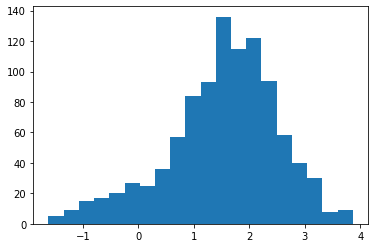

In [37]:
import matplotlib.pyplot as plt

def log_prob(x):
  return tfpd.Normal(0, 1).log_prob(x)

def custom_proposal(state, extra):
  return state + tfpd.Uniform(-.5, .75).sample()

kernel = tfp.mcmc.RandomWalkMetropolis(log_prob, new_state_fn=custom_proposal)
state = tfpd.Normal(0, 1).sample()
kernel_results = kernel.bootstrap_results(state)
samples = []
for _ in range(1000):
  state, kernel_results = kernel.one_step(state, kernel_results)
  samples.append(state)

plt.hist(samples, bins=20)


In [38]:
print(kernel_results.accepted_results)

UncalibratedRandomWalkResults(
  log_acceptance_correction=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
  target_log_prob=<tf.Tensor: shape=(), dtype=float32, numpy=-2.8183923>,
  seed=[]
)


In [40]:
np.shape(samples)

(1000,)